
Results for Stacking Classifier:
Accuracy: 0.9841269841269841
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       531
           1       0.97      0.93      0.95        99

    accuracy                           0.98       630
   macro avg       0.98      0.96      0.97       630
weighted avg       0.98      0.98      0.98       630



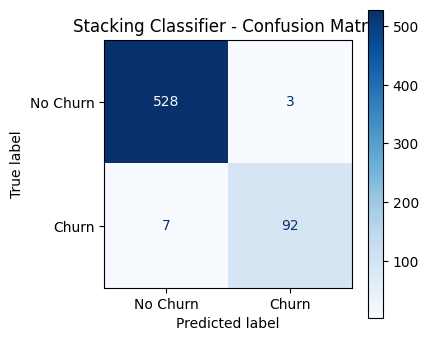


Results for Voting Classifier:
Accuracy: 0.9682539682539683
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       531
           1       0.99      0.81      0.89        99

    accuracy                           0.97       630
   macro avg       0.98      0.90      0.94       630
weighted avg       0.97      0.97      0.97       630



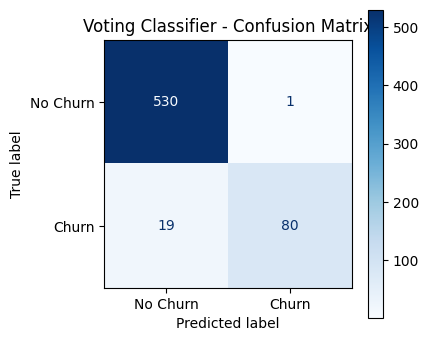


Results for Best Stacking Classifier:
Accuracy: 0.9841269841269841
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       531
           1       0.97      0.93      0.95        99

    accuracy                           0.98       630
   macro avg       0.98      0.96      0.97       630
weighted avg       0.98      0.98      0.98       630



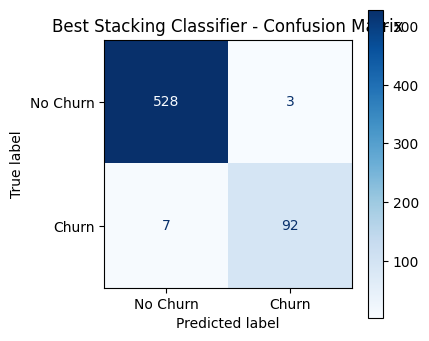


Results for Final Ensemble:
Accuracy: 0.9825396825396825
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       531
           1       0.98      0.91      0.94        99

    accuracy                           0.98       630
   macro avg       0.98      0.95      0.97       630
weighted avg       0.98      0.98      0.98       630



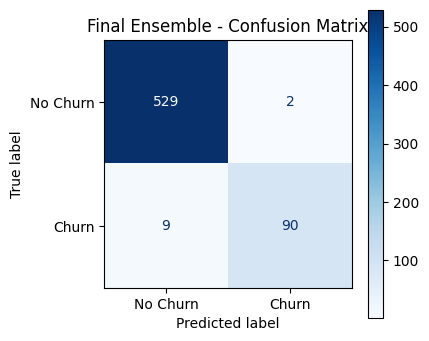

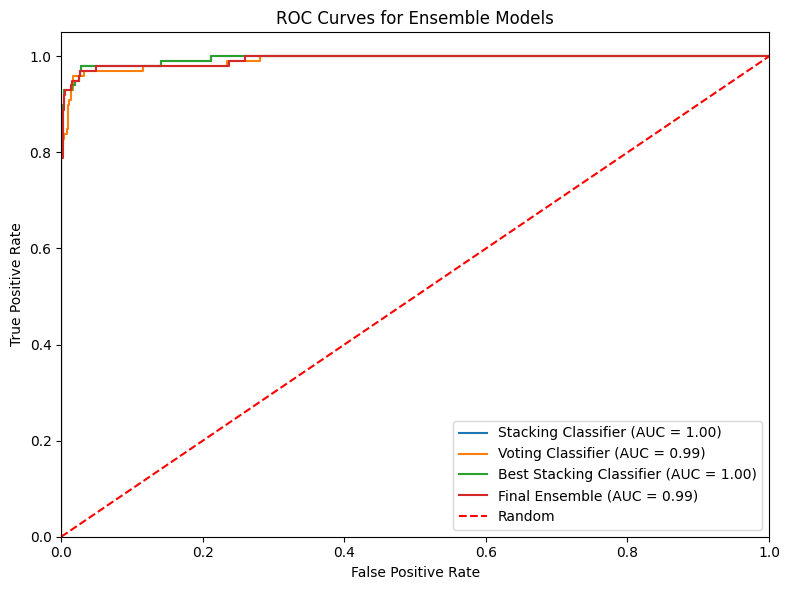

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    roc_curve, roc_auc_score, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
)
from xgboost import XGBClassifier
from sklearn.svm import SVC

df = pd.read_csv('Customer_Churn_Modified.csv')

target_column = 'Churn'

X = df.drop(columns=[target_column])
y = df[target_column]

if y.dtype == object:
    y = LabelEncoder().fit_transform(y)

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=[np.number]).columns

for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

base_estimators = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('svc', SVC(kernel='rbf', probability=True, random_state=42))
]

final_estimator = LogisticRegression(max_iter=1000, random_state=42)

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    passthrough=False,
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)

voting_clf = VotingClassifier(
    estimators=base_estimators,
    voting='soft',  
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)
y_pred_vote = voting_clf.predict(X_test)

param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 5],
}

grid = GridSearchCV(
    estimator=stacking_clf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_stacking_model = grid.best_estimator_
y_pred_best_stack = best_stacking_model.predict(X_test)

final_ensemble = VotingClassifier(
    estimators=[
        ('stack', stacking_clf),  
        ('vote_clf', voting_clf), 
    ],
    voting='soft'
)

final_ensemble.fit(X_train, y_train)
y_pred_final = final_ensemble.predict(X_test)

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = np.zeros_like(y_pred, dtype=float)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    print(f"\nResults for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
    ax.set_title(f"{model_name} - Confusion Matrix")
    plt.show()

    fpr_vals, tpr_vals, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    return {
        "Model Name": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "TPR": tpr,
        "FPR": fpr,
        "ROC AUC": auc_score,
        "Confusion Matrix": cm
    }

models = [
    ("Stacking Classifier", stacking_clf),
    ("Voting Classifier", voting_clf),
    ("Best Stacking Classifier", best_stacking_model),
    ("Final Ensemble", final_ensemble)
]

results = []
for name, model in models:
    result = evaluate_model(model, X_test, y_test, model_name=name)
    results.append(result)

results_df = pd.DataFrame(results)

excel_filename = "Ensemble_Model_Results.xlsx"
results_df.drop(columns=["Confusion Matrix"], inplace=True)
results_df.to_excel(excel_filename, index=False)


plt.figure(figsize=(8, 6))
for name, model in models:
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros_like(y_test)
    fpr_vals, tpr_vals, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr_vals, tpr_vals, label=f"{name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Ensemble Models")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Fixed classifier; you can change it
from sklearn.preprocessing import (
    StandardScaler, FunctionTransformer, PowerTransformer,
    KBinsDiscretizer
)
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import scorecardpy as sc
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

def main():
    """
    Comprehensive script focusing solely on PCA:
    - Applies various data transformations.
    - Applies PCA with different numbers of components.
    - Trains a fixed classifier.
    - Evaluates and identifies the best PCA configuration.
    """
    # -----------------------------
    # 1. Load the Dataset
    # -----------------------------
    try:
        dataset = pd.read_csv('Customer_Churn_Modified.csv')
        print("Dataset loaded successfully.\n")
    except FileNotFoundError:
        print("Error: 'Customer_Churn_Modified.csv' not found.")
        return

    # -----------------------------
    # 2. Define Features and Target
    # -----------------------------
    target_variable = 'Churn'  # Ensure this matches your dataset
    features = [col for col in dataset.columns if col != target_variable]

    X = dataset[features]
    y = dataset[target_variable]

    print(f"Features Shape: {X.shape}")
    print(f"Target Shape: {y.shape}\n")

    # -----------------------------
    # 3. Split into Train/Test
    # -----------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    print(f"Training Set Shape: {X_train.shape}, {y_train.shape}")
    print(f"Testing Set Shape: {X_test.shape}, {y_test.shape}\n")

    # -----------------------------
    # 4. Define Resampling Methods
    # -----------------------------
    resampling_methods = {
        "No Resampling": None,
        "SMOTE": SMOTE(random_state=42),
        "Random Oversampling": RandomOverSampler(random_state=42),
        "Random Undersampling": RandomUnderSampler(random_state=42),
        "SMOTEENN": SMOTEENN(random_state=42)
    }

    # -----------------------------
    # 5. Define Data Transformations
    # -----------------------------
    transformations = {
        "Log Transformation": FunctionTransformer(np.log1p, validate=True),  # log(1 + x) to handle zeros
        "Rank Transformation": FunctionTransformer(
            lambda x: pd.DataFrame(x, columns=X.columns).rank(axis=0).to_numpy(), validate=True
        ),
        "Box-Cox Transformation": PowerTransformer(method='box-cox'),
        "Z-score Standardization": StandardScaler(),
        "Discretization": KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'),
        "WOE Transformation": "woe",  # Placeholder for WOE
    }

    # Check if Box-Cox is applicable (all features must be > 0)
    if (X <= 0).any().any():
        print("Skipping Box-Cox Transformation due to non-positive values in the dataset.\n")
        del transformations["Box-Cox Transformation"]

    # -----------------------------
    # 6. Define PCA Options
    # -----------------------------
    dimensionality_reductions = {
        "No PCA": None,
        "PCA (5 components)": PCA(n_components=5),
        "PCA (10 components)": PCA(n_components=10),
        "PCA (15 components)": PCA(n_components=15)
    }

    # -----------------------------
    # 7. Initialize Classifier
    # -----------------------------
    classifier = RandomForestClassifier(random_state=42)  # Fixed classifier

    # -----------------------------
    # 8. Initialize Resampler
    # -----------------------------
    # For simplicity, we'll use only one resampling method or loop through
    # Here, we'll loop through all resampling methods
    # To focus on PCA, you can select a specific resampling method

    # -----------------------------
    # 9. Storage for Results
    # -----------------------------
    results = []

    # -----------------------------
    # 10. Helper Function: Apply Transformation
    # -----------------------------
    def apply_transformation(transformer, X_train, X_test, y_train=None):
        if transformer == "woe":
            # Use scorecardpy WOE
            try:
                bins = sc.woebin(pd.concat([X_train, y_train], axis=1), y=target_variable)
                X_train_transformed = sc.woebin_ply(X_train, bins)
                X_test_transformed = sc.woebin_ply(X_test, bins)
            except Exception as e:
                print(f"WOE Transformation failed: {e}")
                raise e
        else:
            transformer.fit(X_train)
            X_train_transformed = transformer.transform(X_train)
            X_test_transformed = transformer.transform(X_test)
        return X_train_transformed, X_test_transformed

    # -----------------------------
    # 11. Main Loop: Iterate Over Transformations and PCA
    # -----------------------------
    for resample_name, resampler in resampling_methods.items():
        for transformation_name, transformer in transformations.items():
            # Apply Resampling
            if resampler:
                X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)
                print(f"Resampling: {resample_name} | Resampled Training Set Shape: {X_resampled.shape}, {y_resampled.shape}")
            else:
                X_resampled, y_resampled = X_train, y_train
                print(f"Resampling: {resample_name} | Training Set Shape: {X_resampled.shape}, {y_resampled.shape}")

            # Apply Transformation
            try:
                X_transformed, X_test_transformed = apply_transformation(
                    transformer, X_resampled, X_test, y_resampled
                )
                print(f"Transformation: {transformation_name} | Transformed Training Set Shape: {X_transformed.shape}, Transformed Testing Set Shape: {X_test_transformed.shape}")
            except Exception as e:
                print(f"Skipping Transformation: {transformation_name} due to error: {e}\n")
                continue

            # Iterate over PCA options
            for pca_name, pca_transformer in dimensionality_reductions.items():
                if pca_transformer is not None:
                    try:
                        pca_transformer.fit(X_transformed)
                        X_pca = pca_transformer.transform(X_transformed)
                        X_test_pca = pca_transformer.transform(X_test_transformed)
                        print(f"PCA Applied: {pca_name} | PCA Training Shape: {X_pca.shape}, PCA Testing Shape: {X_test_pca.shape}")
                    except Exception as e:
                        print(f"Skipping PCA: {pca_name} due to error: {e}\n")
                        continue
                else:
                    X_pca = X_transformed
                    X_test_pca = X_test_transformed
                    print(f"PCA Applied: {pca_name} | No PCA | Training Shape: {X_pca.shape}, Testing Shape: {X_test_pca.shape}")

                # Train the Classifier
                try:
                    classifier.fit(X_pca, y_resampled)
                    y_pred = classifier.predict(X_test_pca)

                    # Calculate Metrics
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred, average='binary')
                    recall = recall_score(y_test, y_pred, average='binary')
                    f1 = f1_score(y_test, y_pred, average='binary')

                    # Store Results
                    results.append({
                        "Resampling": resample_name,
                        "Transformation": transformation_name,
                        "Dimensionality_Reduction": pca_name,
                        "Accuracy": accuracy,
                        "Precision": precision,
                        "Recall": recall,
                        "F1_Score": f1
                    })

                    print(f"Model Trained | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}\n")

                except Exception as e:
                    print(f"Error training classifier with Resampling: {resample_name}, Transformation: {transformation_name}, PCA: {pca_name} - {e}\n")
                    continue

    # -----------------------------
    # 12. Compile Results
    # -----------------------------
    results_df = pd.DataFrame(results)

    # Save to Excel
    excel_filename = "PCA_Focused_Classifier_Results.xlsx"
    results_df.to_excel(excel_filename, index=False)
    print(f"\nAll results have been saved to '{excel_filename}'.\n")

    # -----------------------------
    # 13. Display Summary Sorted by F1-Score
    # -----------------------------
    print("Summary of Classifier Evaluation (Sorted by F1-Score):")
    sorted_results = results_df.sort_values(by=["F1_Score"], ascending=False).reset_index(drop=True)
    print(sorted_results)

    # -----------------------------
    # 14. Identify the Best Configuration
    # -----------------------------
    best_entry = sorted_results.iloc[0]
    best_resampling = best_entry["Resampling"]
    best_transformation = best_entry["Transformation"]
    best_pca = best_entry["Dimensionality_Reduction"]
    best_accuracy = best_entry["Accuracy"]
    best_precision = best_entry["Precision"]
    best_recall = best_entry["Recall"]
    best_f1 = best_entry["F1_Score"]

    print("\n======================================================")
    print("BEST MODEL CONFIGURATION (by F1-Score):")
    print(f"Resampling Method     : {best_resampling}")
    print(f"Data Transformation   : {best_transformation}")
    print(f"PCA Configuration     : {best_pca}")
    print(f"Accuracy              : {best_accuracy:.4f}")
    print(f"Precision             : {best_precision:.4f}")
    print(f"Recall                : {best_recall:.4f}")
    print(f"F1-Score              : {best_f1:.4f}")
    print("======================================================\n")

    # -----------------------------
    # 15. Retrain Best Model and Evaluate
    # -----------------------------
    print("Retraining the Best Model on the Entire Training Set and Evaluating on Test Set...\n")

    # Apply Resampling
    if best_resampling:
        final_resampler = resampling_methods[best_resampling]
        X_train_final, y_train_final = final_resampler.fit_resample(X_train, y_train)
    else:
        X_train_final, y_train_final = X_train, y_train

    # Apply Transformation
    try:
        X_train_final_trans, X_test_final_trans = apply_transformation(
            best_transformation, X_train_final, X_test, y_train_final
        )
    except Exception as e:
        print(f"Error applying transformation '{best_transformation}': {e}")
        return

    # Apply PCA
    if best_pca != "No PCA":
        final_pca_transformer = dimensionality_reductions[best_pca]
        try:
            final_pca_transformer.fit(X_train_final_trans)
            X_train_final_pca = final_pca_transformer.transform(X_train_final_trans)
            X_test_final_pca = final_pca_transformer.transform(X_test_final_trans)
        except Exception as e:
            print(f"Error applying PCA '{best_pca}': {e}")
            return
    else:
        X_train_final_pca = X_train_final_trans
        X_test_final_pca = X_test_final_trans

    # Train the Classifier
    try:
        classifier.fit(X_train_final_pca, y_train_final)
        y_pred_final = classifier.predict(X_test_final_pca)

        # Calculate Metrics
        final_accuracy = accuracy_score(y_test, y_pred_final)
        final_precision = precision_score(y_test, y_pred_final, average='binary')
        final_recall = recall_score(y_test, y_pred_final, average='binary')
        final_f1 = f1_score(y_test, y_pred_final, average='binary')

        # Print Final Evaluation
        print(f"Results for Best {classifier.__class__.__name__} Configuration:")
        print(f"Accuracy: {final_accuracy}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred_final))

        # Optional: Plot Confusion Matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(
            confusion_matrix(y_test, y_pred_final),
            annot=True,
            fmt="d",
            cmap="Blues"
        )
        plt.title(f"Confusion Matrix - Best {classifier.__class__.__name__}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    except Exception as e:
        print(f"Error during final model training/evaluation: {e}")

if __name__ == "__main__":
    main()


Dataset loaded successfully.

Features Shape: (3150, 13)
Target Shape: (3150,)

Training Set Shape: (2520, 13), (2520,)
Testing Set Shape: (630, 13), (630,)

Skipping Box-Cox Transformation due to non-positive values in the dataset.

Resampling: No Resampling | Training Set Shape: (2520, 13), (2520,)
Transformation: Log Transformation | Transformed Training Set Shape: (2520, 13), Transformed Testing Set Shape: (630, 13)
PCA Applied: No PCA | No PCA | Training Shape: (2520, 13), Testing Shape: (630, 13)
Model Trained | Accuracy: 0.9778 | Precision: 0.9885 | Recall: 0.8687 | F1-Score: 0.9247

PCA Applied: PCA (5 components) | PCA Training Shape: (2520, 5), PCA Testing Shape: (630, 5)
Model Trained | Accuracy: 0.9317 | Precision: 0.8784 | Recall: 0.6566 | F1-Score: 0.7514

PCA Applied: PCA (10 components) | PCA Training Shape: (2520, 10), PCA Testing Shape: (630, 10)
Model Trained | Accuracy: 0.9587 | Precision: 0.9740 | Recall: 0.7576 | F1-Score: 0.8523

Skipping PCA: PCA (15 components)

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Trained | Accuracy: 0.8429 | Precision: 0.0000 | Recall: 0.0000 | F1-Score: 0.0000

PCA Applied: PCA (10 components) | PCA Training Shape: (4248, 10), PCA Testing Shape: (630, 10)


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Trained | Accuracy: 0.8429 | Precision: 0.0000 | Recall: 0.0000 | F1-Score: 0.0000

Skipping PCA: PCA (15 components) due to error: n_components=15 must be between 0 and min(n_samples, n_features)=13 with svd_solver='covariance_eigh'

Resampling: Random Oversampling | Resampled Training Set Shape: (4248, 13), (4248,)
Transformation: Z-score Standardization | Transformed Training Set Shape: (4248, 13), Transformed Testing Set Shape: (630, 13)
PCA Applied: No PCA | No PCA | Training Shape: (4248, 13), Testing Shape: (630, 13)
Model Trained | Accuracy: 0.9794 | Precision: 0.9388 | Recall: 0.9293 | F1-Score: 0.9340

PCA Applied: PCA (5 components) | PCA Training Shape: (4248, 5), PCA Testing Shape: (630, 5)
Model Trained | Accuracy: 0.9635 | Precision: 0.8958 | Recall: 0.8687 | F1-Score: 0.8821

PCA Applied: PCA (10 components) | PCA Training Shape: (4248, 10), PCA Testing Shape: (630, 10)
Model Trained | Accuracy: 0.9746 | Precision: 0.9368 | Recall: 0.8990 | F1-Score: 0.9175

Skipp

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model Trained | Accuracy: 0.8429 | Precision: 0.0000 | Recall: 0.0000 | F1-Score: 0.0000

Skipping PCA: PCA (15 components) due to error: n_components=15 must be between 0 and min(n_samples, n_features)=13 with svd_solver='covariance_eigh'

Resampling: SMOTEENN | Resampled Training Set Shape: (3453, 13), (3453,)
Transformation: Z-score Standardization | Transformed Training Set Shape: (3453, 13), Transformed Testing Set Shape: (630, 13)
PCA Applied: No PCA | No PCA | Training Shape: (3453, 13), Testing Shape: (630, 13)
Model Trained | Accuracy: 0.9111 | Precision: 0.6483 | Recall: 0.9495 | F1-Score: 0.7705

PCA Applied: PCA (5 components) | PCA Training Shape: (3453, 5), PCA Testing Shape: (630, 5)
Model Trained | Accuracy: 0.8857 | Precision: 0.5828 | Recall: 0.9596 | F1-Score: 0.7252

PCA Applied: PCA (10 components) | PCA Training Shape: (3453, 10), PCA Testing Shape: (630, 10)
Model Trained | Accuracy: 0.9079 | Precision: 0.6395 | Recall: 0.9495 | F1-Score: 0.7642

Skipping PCA: PC

Dataset loaded successfully.
Features Shape: (3150, 13)
Target Shape: (3150,)



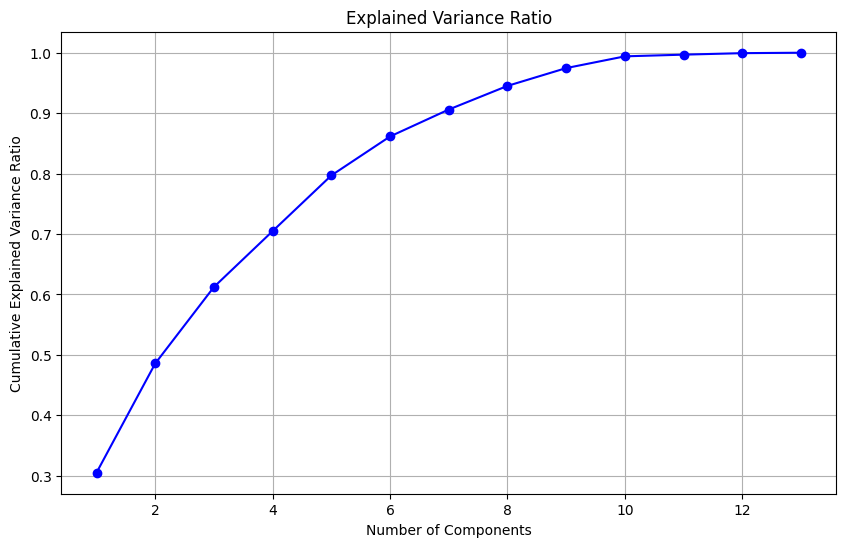


Optimal number of components for 95% variance: 9

Optimizing PCA and classifier parameters...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi


Best parameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 200, 'pca__n_components': 10}
Best cross-validation F1 score: 0.8403

Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       531
           1       0.94      0.81      0.87        99

    accuracy                           0.96       630
   macro avg       0.95      0.90      0.92       630
weighted avg       0.96      0.96      0.96       630


Analyzing feature importance...


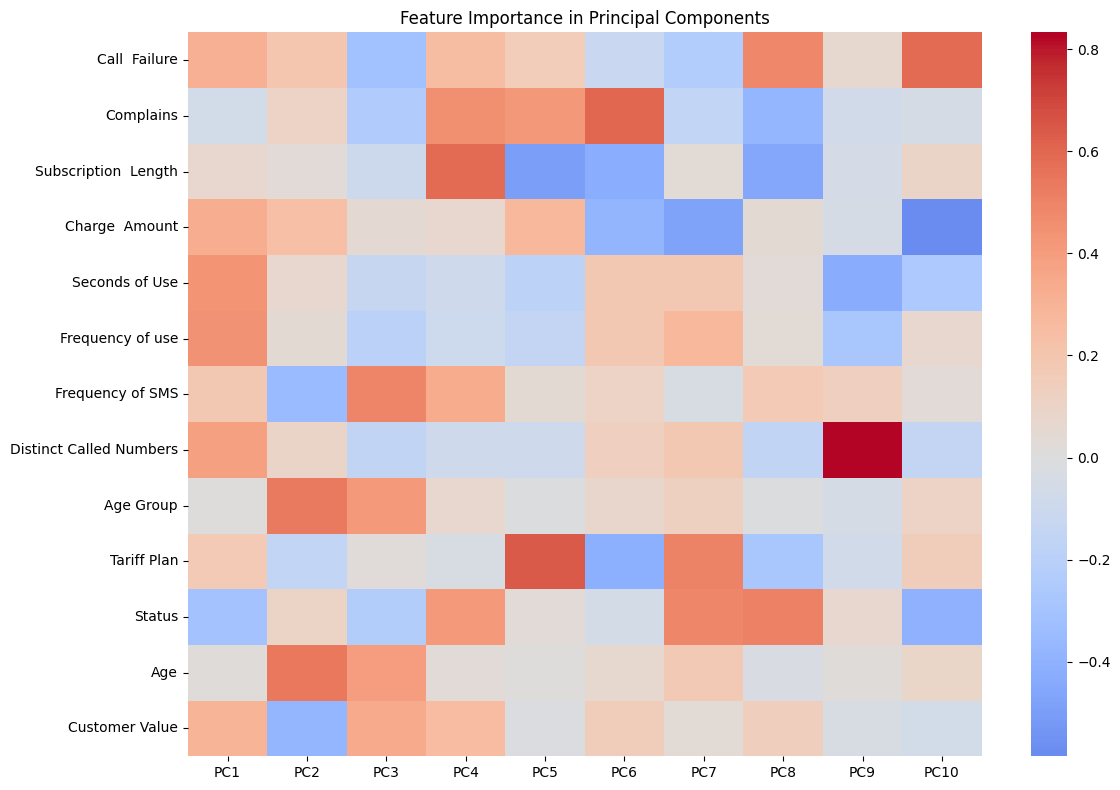


Model saved as 'best_pca_model.joblib'


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PowerTransformer, KBinsDiscretizer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import scorecardpy as sc
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib

warnings.filterwarnings("ignore", category=FutureWarning)

class PCAAnalyzer:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.best_pipeline = None
        self.explained_variance_ratios_ = None
        
    def load_data(self, file_path, target_variable):
        """Load and prepare dataset"""
        try:
            dataset = pd.read_csv(file_path)
            features = [col for col in dataset.columns if col != target_variable]
            return dataset[features], dataset[target_variable]
        except FileNotFoundError:
            raise FileNotFoundError(f"Dataset not found at {file_path}")

    def plot_explained_variance(self, pca_transformer, title="Explained Variance Ratio"):
        """Plot cumulative explained variance ratio"""
        plt.figure(figsize=(10, 6))
        cumsum = np.cumsum(pca_transformer.explained_variance_ratio_)
        plt.plot(range(1, len(cumsum) + 1), cumsum, 'bo-')
        plt.grid(True)
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.title(title)
        plt.show()
        
     
        self.explained_variance_ratios_ = pca_transformer.explained_variance_ratio_

    def get_optimal_components(self, variance_threshold=0.95):
        """Get optimal number of components based on explained variance threshold"""
        if self.explained_variance_ratios_ is None:
            raise ValueError("No PCA has been performed yet")
        cumsum = np.cumsum(self.explained_variance_ratios_)
        return np.argmax(cumsum >= variance_threshold) + 1

    def create_pipeline(self, n_components, transformation='standard', sampling=None):
        """Create a pipeline with specified preprocessing, PCA, and classifier"""
        steps = []
       
        if transformation == 'standard':
            steps.append(('scaler', StandardScaler()))
        elif transformation == 'log':
            steps.append(('scaler', FunctionTransformer(np.log1p)))
        elif transformation == 'box-cox':
            steps.append(('scaler', PowerTransformer(method='box-cox')))
            
        
        steps.append(('pca', PCA(n_components=n_components)))
        
     
        if sampling == 'smote':
            steps.append(('sampling', SMOTE(random_state=self.random_state)))
        elif sampling == 'random_over':
            steps.append(('sampling', RandomOverSampler(random_state=self.random_state)))
        elif sampling == 'random_under':
            steps.append(('sampling', RandomUnderSampler(random_state=self.random_state)))
        elif sampling == 'smoteenn':
            steps.append(('sampling', SMOTEENN(random_state=self.random_state)))
            
   
        steps.append(('classifier', RandomForestClassifier(random_state=self.random_state)))
        
        return Pipeline(steps)

    def optimize_pca(self, X, y, cv=5):
        """Perform grid search to find optimal parameters"""
     
        param_grid = {
            'pca__n_components': [5, 10, 15, 20],
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None],
        }
        
     
        pipeline = self.create_pipeline(n_components=10) 
        
      
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1
        )
        grid_search.fit(X, y)
        
        self.best_pipeline = grid_search.best_estimator_
        return grid_search.best_params_, grid_search.best_score_

    def analyze_feature_importance(self, feature_names):
        """Analyze feature importance after PCA transformation"""
        if self.best_pipeline is None:
            raise ValueError("No model has been trained yet")
            
        pca = self.best_pipeline.named_steps['pca']
        components = pca.components_
        
      
        feature_importance = pd.DataFrame(
            components.T,
            columns=[f'PC{i+1}' for i in range(components.shape[0])],
            index=feature_names
        )
        
     
        plt.figure(figsize=(12, 8))
        sns.heatmap(feature_importance, cmap='coolwarm', center=0)
        plt.title('Feature Importance in Principal Components')
        plt.tight_layout()
        plt.show()
        
        return feature_importance

    def save_model(self, filepath):
        """Save the trained pipeline"""
        if self.best_pipeline is None:
            raise ValueError("No model has been trained yet")
        joblib.dump(self.best_pipeline, filepath)

def main():
    
    analyzer = PCAAnalyzer()
    
   
    try:
        X, y = analyzer.load_data('Customer_Churn_Modified.csv', 'Churn')
        print("Dataset loaded successfully.")
        print(f"Features Shape: {X.shape}")
        print(f"Target Shape: {y.shape}\n")
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return

   
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

   
    initial_pca = PCA()
    initial_pca.fit(StandardScaler().fit_transform(X_train))
    analyzer.plot_explained_variance(initial_pca)
    
  
    optimal_components = analyzer.get_optimal_components(variance_threshold=0.95)
    print(f"\nOptimal number of components for 95% variance: {optimal_components}")

  
    print("\nOptimizing PCA and classifier parameters...")
    best_params, best_score = analyzer.optimize_pca(X_train, y_train)
    print(f"\nBest parameters: {best_params}")
    print(f"Best cross-validation F1 score: {best_score:.4f}")

 
    y_pred = analyzer.best_pipeline.predict(X_test)
    print("\nTest Set Performance:")
    print(classification_report(y_test, y_pred))

   
    print("\nAnalyzing feature importance...")
    feature_importance = analyzer.analyze_feature_importance(X.columns)

  

if __name__ == "__main__":
    main()